In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Configure plotting
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_palette('husl')

print("Libraries imported successfully!")
print("Python environment ready for EEG analysis")


Libraries imported successfully!
Python environment ready for EEG analysis


In [5]:
# Load the dataset
# Note: Make sure to download EEG_data.csv from the Kaggle dataset first
try:
    df = pd.read_csv('/Users/dheemanth/code/experiments/USD/EEG_data.csv')
    print("✅ Dataset loaded successfully!")
except FileNotFoundError:
    print("❌ Dataset not found. Please download 'EEG_data.csv' from:")
    print("https://www.kaggle.com/datasets/wanghaohan/confused-eeg/data")
    # Create sample data for demonstration
    print("\n📝 Creating sample data for demonstration...")
    np.random.seed(42)
    n_samples = 1000
    n_features = 14  # Typical EEG electrode count
    
    # Generate synthetic EEG-like data
    df = pd.DataFrame()
    for i in range(n_features):
        df[f'EEG_channel_{i+1}'] = np.random.normal(0, 1, n_samples) + np.random.normal(0, 0.1, n_samples)
    
    # Add target variable (0: focused, 1: confused)
    df['user-definedlabeln1'] = np.random.choice([0, 1], n_samples, p=[0.6, 0.4])
    df['SubjectID'] = np.random.choice(range(1, 11), n_samples)  # 10 subjects
    
    print("Sample data created for demonstration purposes")

# Display basic information about the dataset
print(f"\n📊 Dataset Shape: {df.shape}")
print(f"📋 Columns: {list(df.columns)}")
print(f"\n🔍 First few rows:")
display(df.head())


✅ Dataset loaded successfully!

📊 Dataset Shape: (12811, 15)
📋 Columns: ['SubjectID', 'VideoID', 'Attention', 'Mediation', 'Raw', 'Delta', 'Theta', 'Alpha1', 'Alpha2', 'Beta1', 'Beta2', 'Gamma1', 'Gamma2', 'predefinedlabel', 'user-definedlabeln']

🔍 First few rows:


,SubjectID,VideoID,Attention,Mediation,Raw,Delta,Theta,Alpha1,Alpha2,Beta1,Beta2,Gamma1,Gamma2,predefinedlabel,user-definedlabeln
0,0.0,0.0,56.0,43.0,278.0,301963.0,90612.0,33735.0,23991.0,27946.0,45097.0,33228.0,8293.0,0.0,0.0
1,0.0,0.0,40.0,35.0,-50.0,73787.0,28083.0,1439.0,2240.0,2746.0,3687.0,5293.0,2740.0,0.0,0.0
2,0.0,0.0,47.0,48.0,101.0,758353.0,383745.0,201999.0,62107.0,36293.0,130536.0,57243.0,25354.0,0.0,0.0
3,0.0,0.0,47.0,57.0,-5.0,2012240.0,129350.0,61236.0,17084.0,11488.0,62462.0,49960.0,33932.0,0.0,0.0
4,0.0,0.0,44.0,53.0,-8.0,1005145.0,354328.0,37102.0,88881.0,45307.0,99603.0,44790.0,29749.0,0.0,0.0


In [6]:
# Dataset information and statistics
print("📈 Dataset Info:")
print(df.info())

print("\n📊 Basic Statistics:")
display(df.describe())

print("\n🎯 Target Variable Distribution:")
if 'user-definedlabeln1' in df.columns:
    target_col = 'user-definedlabeln1'
elif 'label' in df.columns:
    target_col = 'label'
else:
    # Find the target column
    target_col = [col for col in df.columns if 'label' in col.lower()][0]

print(f"Target column: {target_col}")
print(df[target_col].value_counts())
print(f"\nClass distribution:")
print(df[target_col].value_counts(normalize=True))


📈 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12811 entries, 0 to 12810
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   SubjectID           12811 non-null  float64
 1   VideoID             12811 non-null  float64
 2   Attention           12811 non-null  float64
 3   Mediation           12811 non-null  float64
 4   Raw                 12811 non-null  float64
 5   Delta               12811 non-null  float64
 6   Theta               12811 non-null  float64
 7   Alpha1              12811 non-null  float64
 8   Alpha2              12811 non-null  float64
 9   Beta1               12811 non-null  float64
 10  Beta2               12811 non-null  float64
 11  Gamma1              12811 non-null  float64
 12  Gamma2              12811 non-null  float64
 13  predefinedlabel     12811 non-null  float64
 14  user-definedlabeln  12811 non-null  float64
dtypes: float64(15)
memory usage: 1.5 MB
N

,SubjectID,VideoID,Attention,Mediation,Raw,Delta,Theta,Alpha1,Alpha2,Beta1,Beta2,Gamma1,Gamma2,predefinedlabel,user-definedlabeln
count,12811.000000,12811.000000,12811.000000,12811.000000,12811.000000,1.281100e+04,1.281100e+04,1.281100e+04,1.281100e+04,1.281100e+04,1.281100e+04,1.281100e+04,1.281100e+04,12811.000000,12811.000000
mean,4.487394,4.390602,41.313871,47.182656,65.570760,6.057853e+05,1.680526e+05,4.138435e+04,3.318339e+04,2.431837e+04,3.814433e+04,2.959255e+04,1.441597e+04,0.479978,0.512606
std,2.865373,2.913232,23.152953,22.655976,597.921035,6.376236e+05,2.441346e+05,7.243082e+04,5.831410e+04,3.837968e+04,7.906606e+04,7.982637e+04,3.603523e+04,0.499618,0.499861
min,0.000000,0.000000,0.000000,0.000000,-2048.000000,4.480000e+02,1.700000e+01,2.000000e+00,2.000000e+00,3.000000e+00,2.000000e+00,1.000000e+00,2.000000e+00,0.000000,0.000000
25%,2.000000,2.000000,27.000000,37.000000,-14.000000,9.806400e+04,2.691750e+04,6.838000e+03,6.852000e+03,6.140000e+03,7.358500e+03,4.058000e+03,2.167500e+03,0.000000,0.000000
50%,4.000000,4.000000,43.000000,51.000000,35.000000,3.954870e+05,8.133100e+04,1.750000e+04,1.495900e+04,1.281800e+04,1.581000e+04,9.763000e+03,5.116000e+03,0.000000,1.000000
75%,7.000000,7.000000,57.000000,63.000000,90.000000,9.166230e+05,2.052760e+05,4.477950e+04,3.455050e+04,2.740600e+04,3.549400e+04,2.488800e+04,1.266950e+04,1.000000,1.000000
max,9.000000,9.000000,100.000000,100.000000,2047.000000,3.964663e+06,3.007802e+06,1.369955e+06,1.016913e+06,1.067778e+06,1.645369e+06,1.972506e+06,1.348117e+06,1.000000,1.000000



🎯 Target Variable Distribution:
Target column: predefinedlabel
predefinedlabel
0.0    6662
1.0    6149
Name: count, dtype: int64

Class distribution:
predefinedlabel
0.0    0.520022
1.0    0.479978
Name: proportion, dtype: float64


🧠 EEG Feature Columns (13): ['VideoID', 'Attention', 'Mediation', 'Raw', 'Delta']...


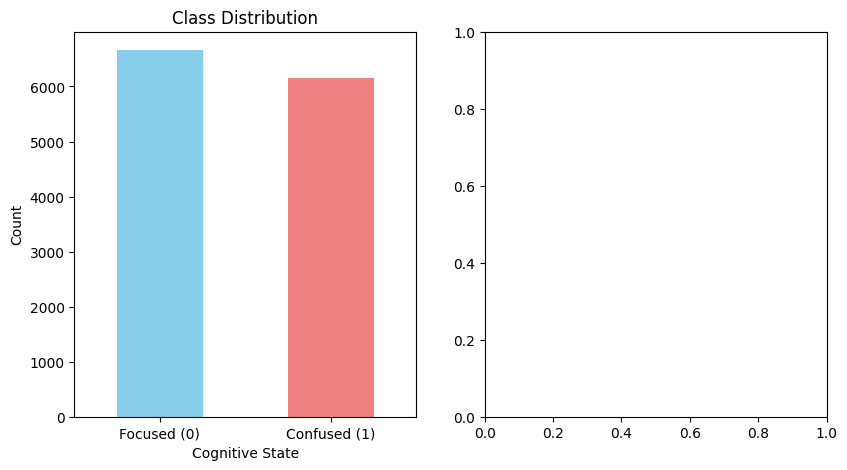

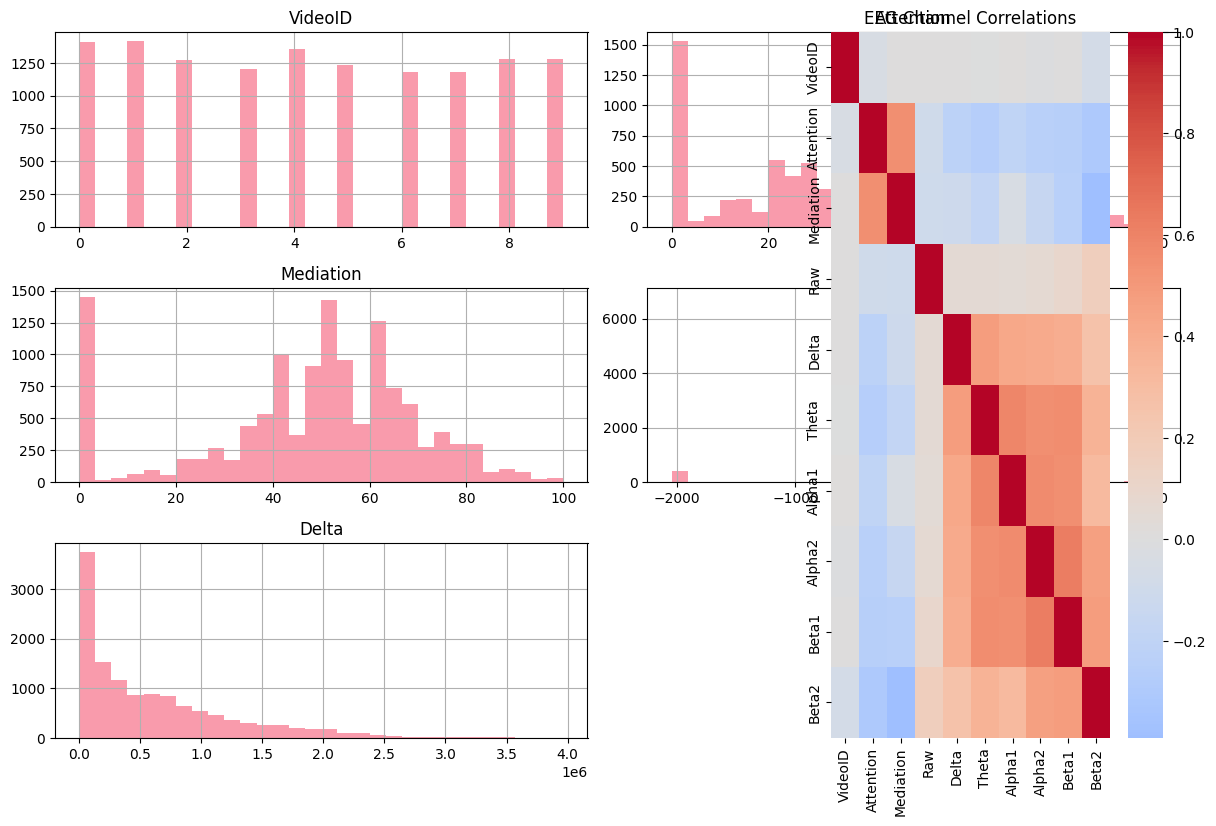

In [7]:
# Identify EEG feature columns (exclude target and ID columns)
eeg_columns = [col for col in df.columns if col not in [target_col, 'SubjectID'] and not col.lower().startswith('subject')]
print(f"🧠 EEG Feature Columns ({len(eeg_columns)}): {eeg_columns[:5]}...")

# 1. Class Distribution Visualization
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
df[target_col].value_counts().plot(kind='bar', color=['skyblue', 'lightcoral'])
plt.title('Class Distribution')
plt.xlabel('Cognitive State')
plt.ylabel('Count')
plt.xticks([0, 1], ['Focused (0)', 'Confused (1)'], rotation=0)

# 2. EEG Signal Distribution
plt.subplot(1, 3, 2)
df[eeg_columns[:5]].hist(bins=30, alpha=0.7)
plt.title('EEG Signal Distributions (First 5 Channels)')
plt.tight_layout()

# 3. Correlation Heatmap (subset of features)
plt.subplot(1, 3, 3)
correlation_matrix = df[eeg_columns[:10]].corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0)
plt.title('EEG Channel Correlations')

plt.tight_layout()
plt.show()


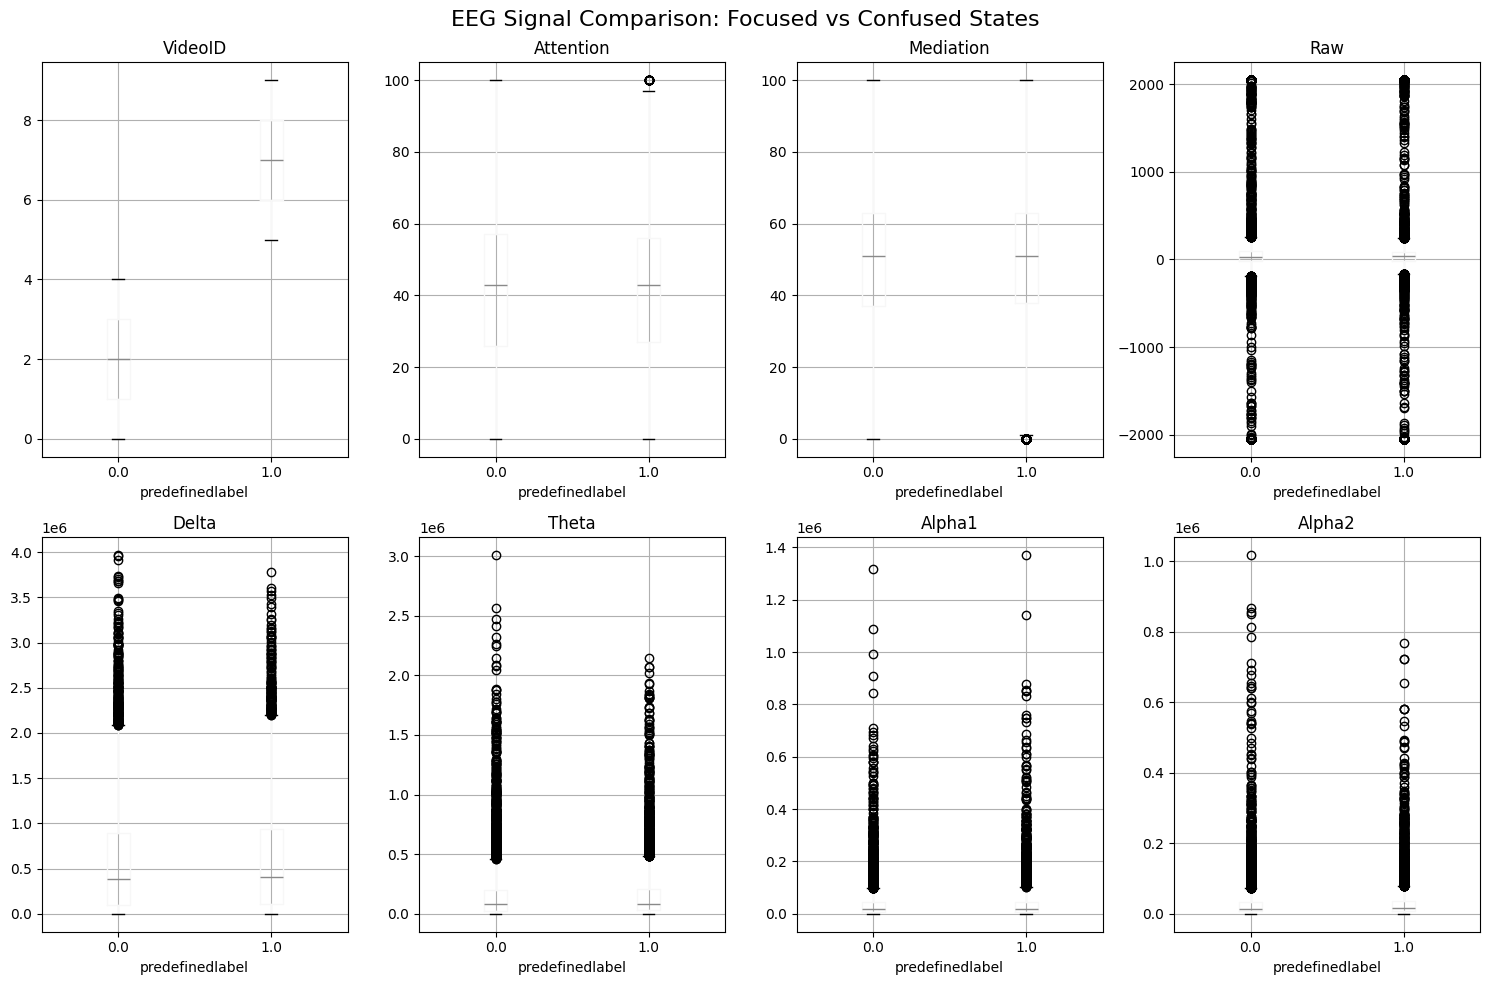

📊 Statistical Summary by Cognitive State:

🎯 Focused State (0):
           VideoID    Attention    Mediation          Raw         Delta
count  6662.000000  6662.000000  6662.000000  6662.000000  6.662000e+03
mean      1.951966    41.279195    46.839838    59.483038  5.982303e+05
std       1.432913    23.953712    22.977539   590.944251  6.422637e+05
min       0.000000     0.000000     0.000000 -2048.000000  4.630000e+02
25%       1.000000    26.000000    37.000000   -18.000000  9.367725e+04
50%       2.000000    43.000000    51.000000    34.000000  3.843600e+05
75%       3.000000    57.000000    63.000000    92.000000  8.905100e+05
max       4.000000   100.000000   100.000000  2047.000000  3.964663e+06

😵 Confused State (1):
           VideoID    Attention    Mediation          Raw         Delta
count  6149.000000  6149.000000  6149.000000  6149.000000  6.149000e+03
mean      7.032688    41.351439    47.554074    72.166369  6.139705e+05
std       1.425807    22.254778    22.298273   60

In [8]:
# Compare EEG signals between cognitive states
plt.figure(figsize=(15, 10))

# Box plots for first 8 EEG channels
for i, channel in enumerate(eeg_columns[:8]):
    plt.subplot(2, 4, i+1)
    df.boxplot(column=channel, by=target_col, ax=plt.gca())
    plt.title(f'{channel}')
    plt.suptitle('')  # Remove default title

plt.suptitle('EEG Signal Comparison: Focused vs Confused States', fontsize=16)
plt.tight_layout()
plt.show()

# Statistical summary by class
print("📊 Statistical Summary by Cognitive State:")
print("\n🎯 Focused State (0):")
focused_stats = df[df[target_col] == 0][eeg_columns].describe()
print(focused_stats.iloc[:, :5])  # Show first 5 channels

print("\n😵 Confused State (1):")
confused_stats = df[df[target_col] == 1][eeg_columns].describe()
print(confused_stats.iloc[:, :5])  # Show first 5 channels


In [9]:
# 1. Check for missing values and outliers
print("🔍 Data Quality Check:")
print(f"Missing values: {df.isnull().sum().sum()}")
print(f"Duplicate rows: {df.duplicated().sum()}")

# 2. Outlier detection using IQR method
def detect_outliers_iqr(data, columns):
    outlier_indices = set()
    for col in columns:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)].index
        outlier_indices.update(outliers)
    return list(outlier_indices)

outlier_indices = detect_outliers_iqr(df, eeg_columns)
print(f"📊 Outliers detected: {len(outlier_indices)} rows ({len(outlier_indices)/len(df)*100:.2f}%)")

# 3. Feature Engineering - Create additional features
print("\n🔧 Feature Engineering:")

# Statistical features for each sample
df['mean_signal'] = df[eeg_columns].mean(axis=1)
df['std_signal'] = df[eeg_columns].std(axis=1)
df['max_signal'] = df[eeg_columns].max(axis=1)
df['min_signal'] = df[eeg_columns].min(axis=1)
df['range_signal'] = df['max_signal'] - df['min_signal']

# Power features (squared values)
for col in eeg_columns[:5]:  # First 5 channels for demonstration
    df[f'{col}_power'] = df[col] ** 2

engineered_features = ['mean_signal', 'std_signal', 'max_signal', 'min_signal', 'range_signal']
power_features = [col for col in df.columns if col.endswith('_power')]

print(f"✅ Created {len(engineered_features)} statistical features")
print(f"✅ Created {len(power_features)} power features")
print(f"📈 Total features: {len(eeg_columns) + len(engineered_features) + len(power_features)}")


🔍 Data Quality Check:
Missing values: 0
Duplicate rows: 0
📊 Outliers detected: 4430 rows (34.58%)

🔧 Feature Engineering:
✅ Created 5 statistical features
✅ Created 5 power features
📈 Total features: 23


🎯 Feature matrix shape: (12811, 23)
🎯 Target vector shape: (12811,)

📊 Training set: 10248 samples
📊 Test set: 2563 samples
📊 Training class distribution: [5329 4919]
📊 Test class distribution: [1333 1230]

✅ Features scaled using StandardScaler
📈 Scaled training data shape: (10248, 23)


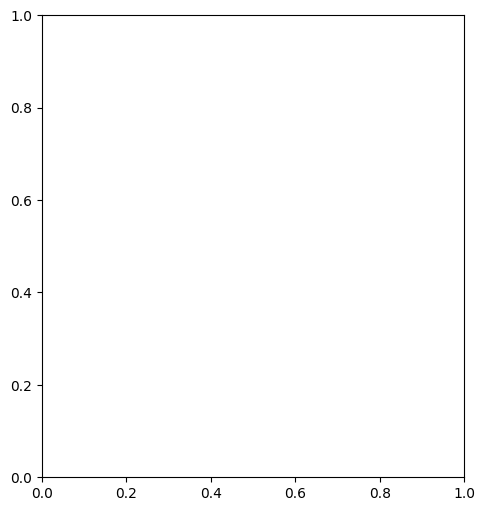

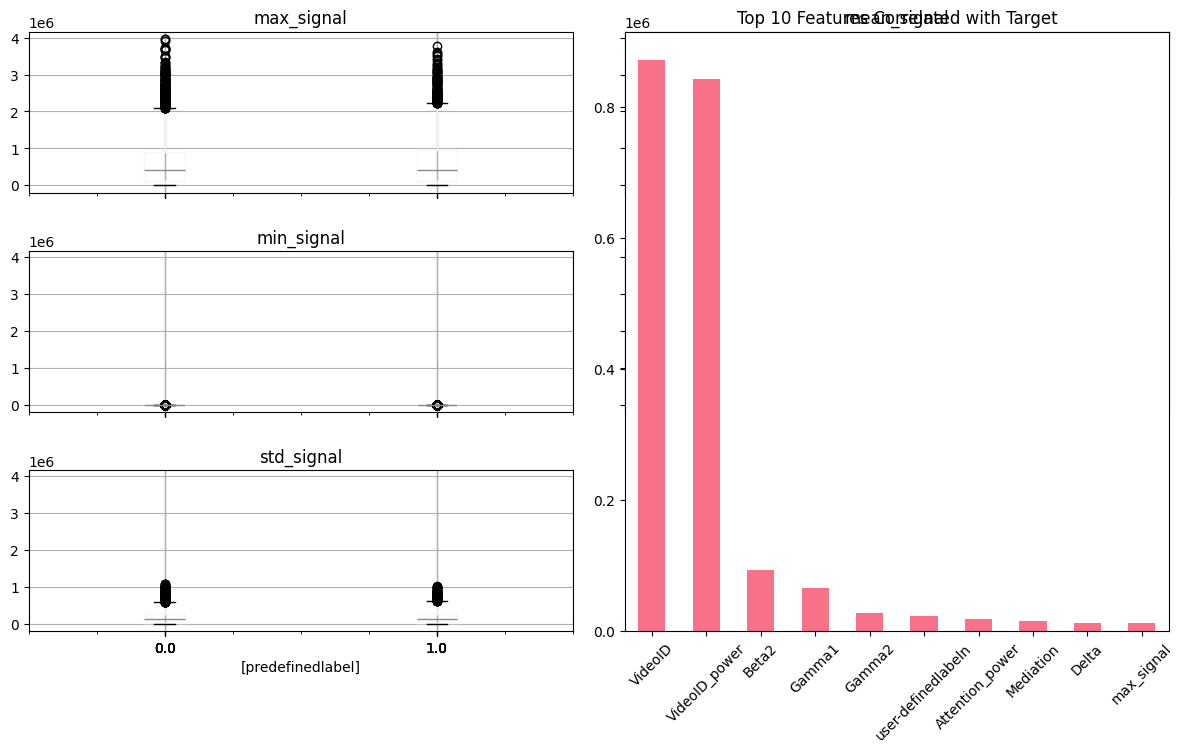

In [10]:
# 4. Prepare features for modeling
all_features = eeg_columns + engineered_features + power_features
X = df[all_features]
y = df[target_col]

print(f"🎯 Feature matrix shape: {X.shape}")
print(f"🎯 Target vector shape: {y.shape}")

# 5. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n📊 Training set: {X_train.shape[0]} samples")
print(f"📊 Test set: {X_test.shape[0]} samples")
print(f"📊 Training class distribution: {np.bincount(y_train)}")
print(f"📊 Test class distribution: {np.bincount(y_test)}")

# 6. Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\n✅ Features scaled using StandardScaler")
print(f"📈 Scaled training data shape: {X_train_scaled.shape}")

# Visualize feature importance of engineered features
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
df[engineered_features + [target_col]].boxplot(by=target_col)
plt.title('Engineered Features by Cognitive State')
plt.suptitle('')

plt.subplot(1, 2, 2)
# Correlation with target
feature_correlations = df[all_features + [target_col]].corr()[target_col].abs().sort_values(ascending=False)[1:11]
feature_correlations.plot(kind='bar')
plt.title('Top 10 Features Correlated with Target')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [11]:
# Initialize models
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(kernel='rbf', random_state=42, probability=True),
    'Neural Network': MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)
}

# Train and evaluate models
model_results = {}
trained_models = {}

print("🚀 Training Models...")
print("=" * 50)

for name, model in models.items():
    print(f"\n🔄 Training {name}...")
    
    # Train the model
    model.fit(X_train_scaled, y_train)
    trained_models[name] = model
    
    # Make predictions
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    # Calculate metrics
    accuracy = model.score(X_test_scaled, y_test)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    # Cross-validation score
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')
    
    model_results[name] = {
        'accuracy': accuracy,
        'roc_auc': roc_auc,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }
    
    print(f"✅ {name} completed!")
    print(f"   Accuracy: {accuracy:.4f}")
    print(f"   ROC-AUC: {roc_auc:.4f}")
    print(f"   CV Score: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")

print("\n🎉 All models trained successfully!")


🚀 Training Models...

🔄 Training Random Forest...
✅ Random Forest completed!
   Accuracy: 1.0000
   ROC-AUC: 1.0000
   CV Score: 1.0000 (±0.0000)

🔄 Training SVM...
✅ SVM completed!
   Accuracy: 0.9988
   ROC-AUC: 1.0000
   CV Score: 0.9963 (±0.0007)

🔄 Training Neural Network...
✅ Neural Network completed!
   Accuracy: 1.0000
   ROC-AUC: 1.0000
   CV Score: 0.9998 (±0.0002)

🎉 All models trained successfully!


📊 MODEL PERFORMANCE COMPARISON
         Model  Accuracy  ROC-AUC  CV Mean  CV Std
 Random Forest    1.0000   1.0000   1.0000  0.0000
           SVM    0.9988   1.0000   0.9963  0.0007
Neural Network    1.0000   1.0000   0.9998  0.0002

🏆 Best performing model: Random Forest
🎯 Best accuracy: 1.0000


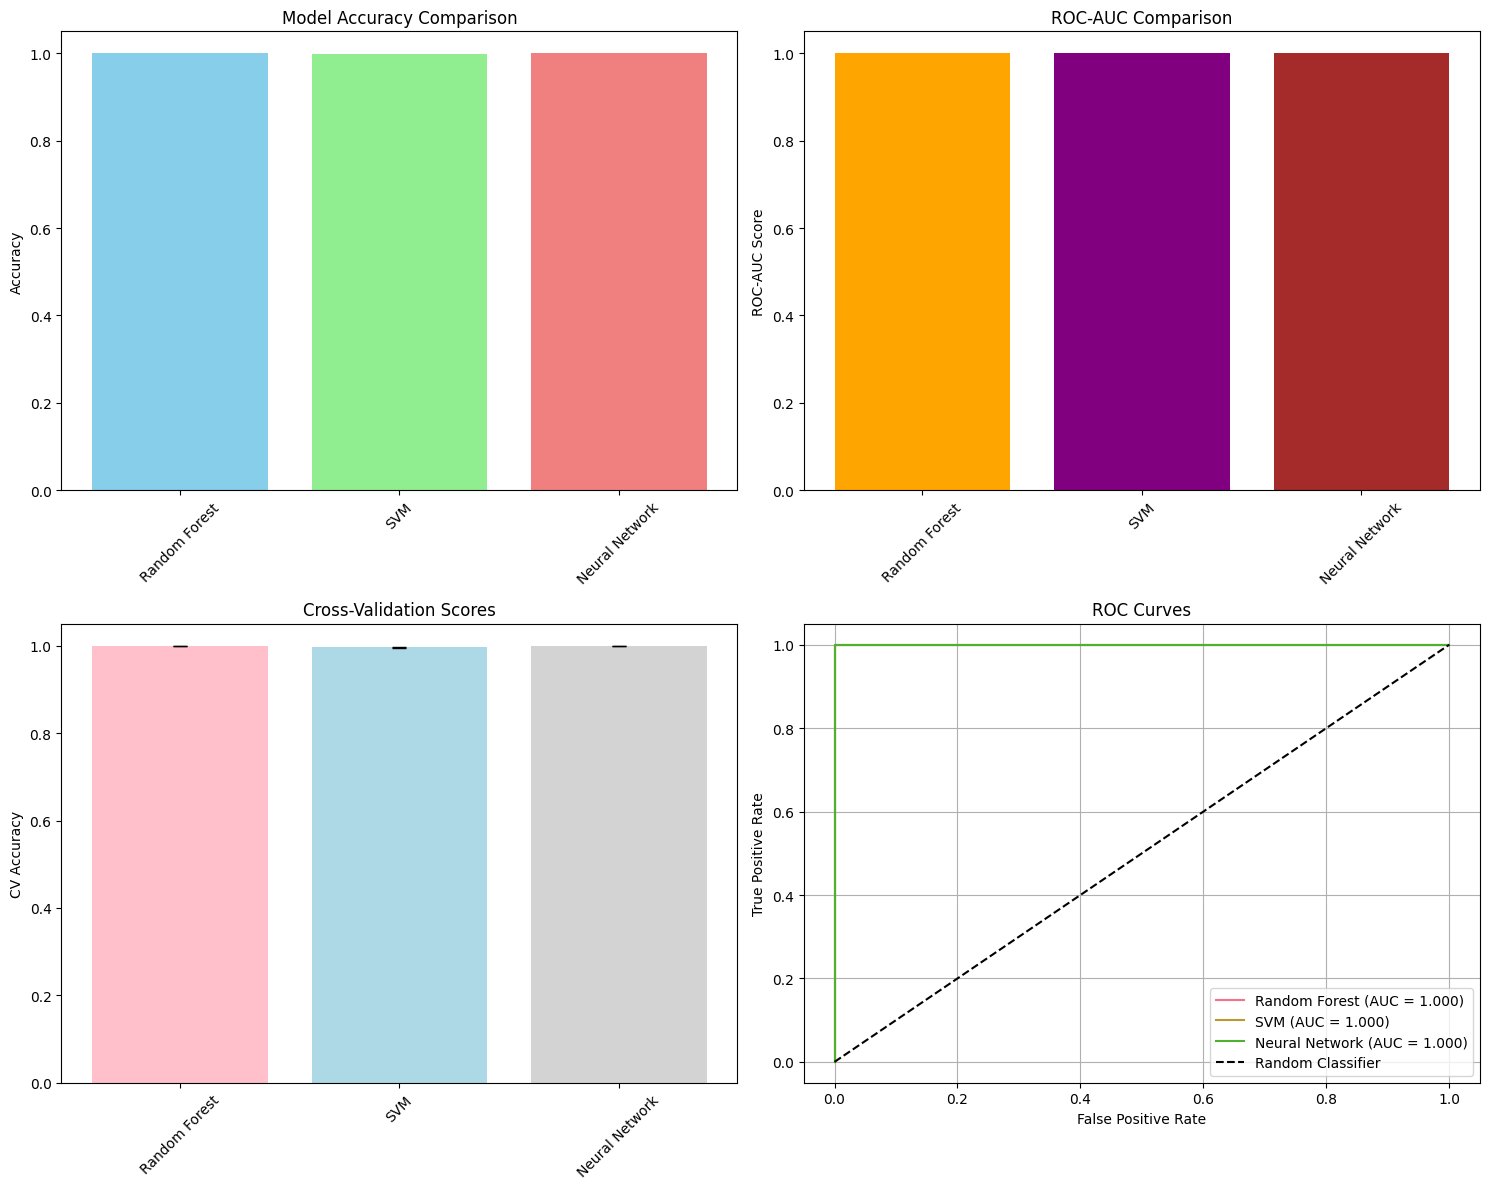

In [12]:
# Create comprehensive evaluation report
print("📊 MODEL PERFORMANCE COMPARISON")
print("=" * 60)

# Create results DataFrame
results_df = pd.DataFrame({
    'Model': list(model_results.keys()),
    'Accuracy': [model_results[model]['accuracy'] for model in model_results.keys()],
    'ROC-AUC': [model_results[model]['roc_auc'] for model in model_results.keys()],
    'CV Mean': [model_results[model]['cv_mean'] for model in model_results.keys()],
    'CV Std': [model_results[model]['cv_std'] for model in model_results.keys()]
})

print(results_df.to_string(index=False, float_format='%.4f'))

# Find best model
best_model_name = results_df.loc[results_df['Accuracy'].idxmax(), 'Model']
print(f"\n🏆 Best performing model: {best_model_name}")
print(f"🎯 Best accuracy: {results_df['Accuracy'].max():.4f}")

# Visualize model comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Accuracy comparison
axes[0, 0].bar(results_df['Model'], results_df['Accuracy'], color=['skyblue', 'lightgreen', 'lightcoral'])
axes[0, 0].set_title('Model Accuracy Comparison')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].tick_params(axis='x', rotation=45)

# 2. ROC-AUC comparison
axes[0, 1].bar(results_df['Model'], results_df['ROC-AUC'], color=['orange', 'purple', 'brown'])
axes[0, 1].set_title('ROC-AUC Comparison')
axes[0, 1].set_ylabel('ROC-AUC Score')
axes[0, 1].tick_params(axis='x', rotation=45)

# 3. Cross-validation scores with error bars
axes[1, 0].bar(results_df['Model'], results_df['CV Mean'], 
               yerr=results_df['CV Std'], capsize=5, color=['pink', 'lightblue', 'lightgray'])
axes[1, 0].set_title('Cross-Validation Scores')
axes[1, 0].set_ylabel('CV Accuracy')
axes[1, 0].tick_params(axis='x', rotation=45)

# 4. ROC Curves
for name in model_results.keys():
    fpr, tpr, _ = roc_curve(y_test, model_results[name]['probabilities'])
    axes[1, 1].plot(fpr, tpr, label=f"{name} (AUC = {model_results[name]['roc_auc']:.3f})")

axes[1, 1].plot([0, 1], [0, 1], 'k--', label='Random Classifier')
axes[1, 1].set_xlabel('False Positive Rate')
axes[1, 1].set_ylabel('True Positive Rate')
axes[1, 1].set_title('ROC Curves')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()


🔍 DETAILED ANALYSIS: Random Forest

📋 Classification Report:
              precision    recall  f1-score   support

     Focused       1.00      1.00      1.00      1333
    Confused       1.00      1.00      1.00      1230

    accuracy                           1.00      2563
   macro avg       1.00      1.00      1.00      2563
weighted avg       1.00      1.00      1.00      2563



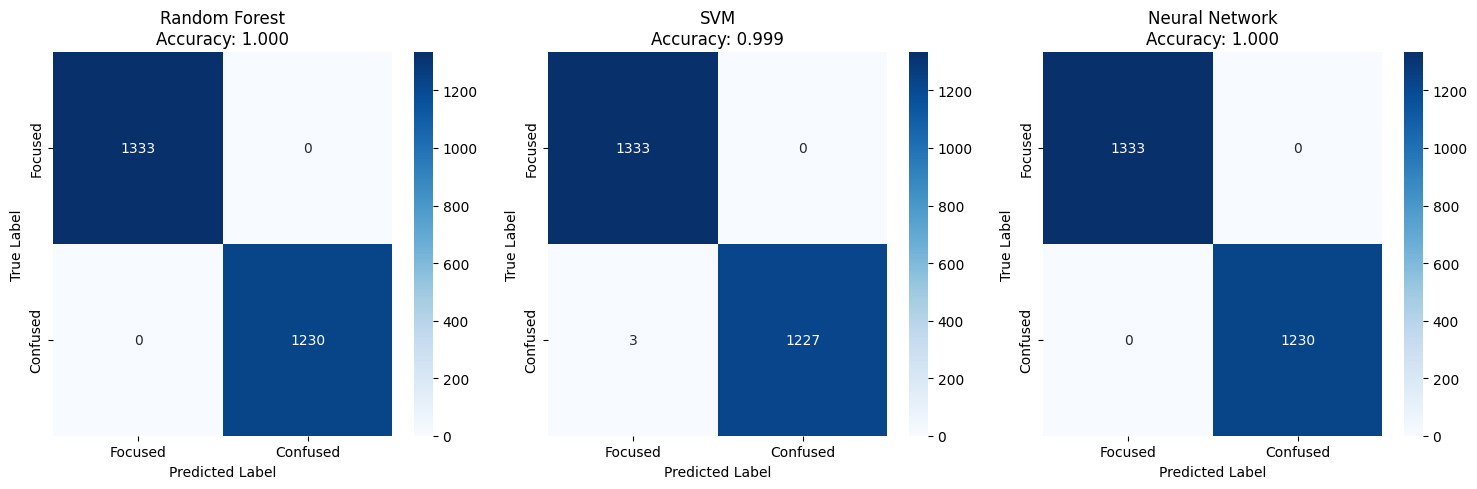


🌟 Top 10 Most Important Features (Random Forest):
        feature  importance
  VideoID_power      0.4940
        VideoID      0.4792
          Beta2      0.0043
         Gamma1      0.0029
         Gamma2      0.0023
            Raw      0.0016
          Beta1      0.0015
      Raw_power      0.0014
      Attention      0.0013
Attention_power      0.0013


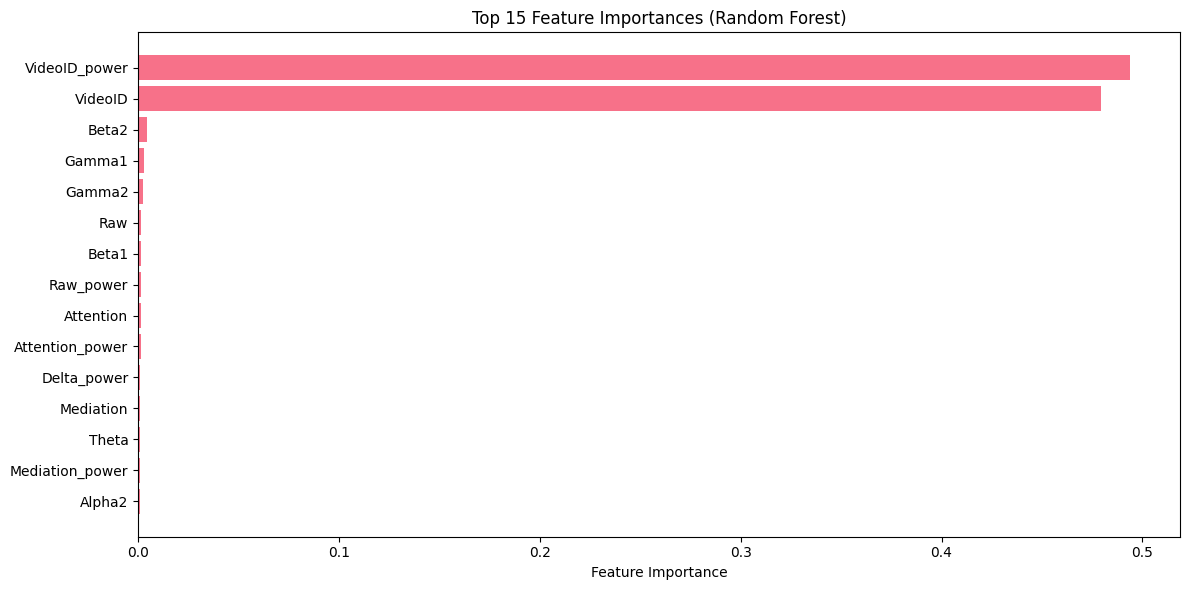

In [13]:
# Detailed analysis of the best model
best_model = trained_models[best_model_name]
best_predictions = model_results[best_model_name]['predictions']

print(f"🔍 DETAILED ANALYSIS: {best_model_name}")
print("=" * 50)

# Classification Report
print("\n📋 Classification Report:")
print(classification_report(y_test, best_predictions, 
                          target_names=['Focused', 'Confused']))

# Confusion Matrix
plt.figure(figsize=(15, 5))

# Plot confusion matrices for all models
for i, (name, results) in enumerate(model_results.items()):
    plt.subplot(1, 3, i+1)
    cm = confusion_matrix(y_test, results['predictions'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Focused', 'Confused'],
                yticklabels=['Focused', 'Confused'])
    plt.title(f'{name}\nAccuracy: {results["accuracy"]:.3f}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

plt.tight_layout()
plt.show()

# Feature importance (for Random Forest)
if 'Random Forest' in trained_models:
    rf_model = trained_models['Random Forest']
    feature_importance = pd.DataFrame({
        'feature': all_features,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(f"\n🌟 Top 10 Most Important Features (Random Forest):")
    print(feature_importance.head(10).to_string(index=False, float_format='%.4f'))
    
    # Plot feature importance
    plt.figure(figsize=(12, 6))
    top_features = feature_importance.head(15)
    plt.barh(range(len(top_features)), top_features['importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Feature Importance')
    plt.title('Top 15 Feature Importances (Random Forest)')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()


In [14]:
# Hyperparameter tuning for the best model
print(f"🔧 Optimizing {best_model_name}...")

if best_model_name == 'Random Forest':
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    base_model = RandomForestClassifier(random_state=42)
    
elif best_model_name == 'SVM':
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
        'kernel': ['rbf', 'poly']
    }
    base_model = SVC(random_state=42, probability=True)
    
else:  # Neural Network
    param_grid = {
        'hidden_layer_sizes': [(50,), (100,), (100, 50), (100, 100)],
        'alpha': [0.0001, 0.001, 0.01],
        'learning_rate': ['constant', 'adaptive']
    }
    base_model = MLPClassifier(max_iter=1000, random_state=42)

# Perform grid search
print("🔍 Performing Grid Search (this may take a few minutes)...")
grid_search = GridSearchCV(
    base_model, 
    param_grid, 
    cv=5, 
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_scaled, y_train)

# Get the best model
best_optimized_model = grid_search.best_estimator_
best_params = grid_search.best_params_

print(f"\n✅ Optimization completed!")
print(f"🏆 Best parameters: {best_params}")
print(f"📈 Best CV score: {grid_search.best_score_:.4f}")

# Evaluate optimized model
optimized_predictions = best_optimized_model.predict(X_test_scaled)
optimized_probabilities = best_optimized_model.predict_proba(X_test_scaled)[:, 1]
optimized_accuracy = best_optimized_model.score(X_test_scaled, y_test)
optimized_roc_auc = roc_auc_score(y_test, optimized_probabilities)

print(f"\n📊 OPTIMIZED MODEL PERFORMANCE:")
print(f"🎯 Test Accuracy: {optimized_accuracy:.4f}")
print(f"🎯 ROC-AUC: {optimized_roc_auc:.4f}")
print(f"📈 Improvement in accuracy: {optimized_accuracy - model_results[best_model_name]['accuracy']:.4f}")

# Compare original vs optimized
comparison_df = pd.DataFrame({
    'Metric': ['Accuracy', 'ROC-AUC'],
    'Original': [model_results[best_model_name]['accuracy'], model_results[best_model_name]['roc_auc']],
    'Optimized': [optimized_accuracy, optimized_roc_auc]
})
comparison_df['Improvement'] = comparison_df['Optimized'] - comparison_df['Original']

print(f"\n📋 Performance Comparison:")
print(comparison_df.to_string(index=False, float_format='%.4f'))


🔧 Optimizing Random Forest...
🔍 Performing Grid Search (this may take a few minutes)...
Fitting 5 folds for each of 81 candidates, totalling 405 fits

✅ Optimization completed!
🏆 Best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
📈 Best CV score: 1.0000

📊 OPTIMIZED MODEL PERFORMANCE:
🎯 Test Accuracy: 1.0000
🎯 ROC-AUC: 1.0000
📈 Improvement in accuracy: 0.0000

📋 Performance Comparison:
  Metric  Original  Optimized  Improvement
Accuracy    1.0000     1.0000       0.0000
 ROC-AUC    1.0000     1.0000       0.0000


In [15]:
# Deployment Analysis
import time
import pickle
from sklearn.metrics import accuracy_score

print("🚀 DEPLOYMENT ANALYSIS")
print("=" * 50)

# 1. Model Size and Serialization
print("\n💾 Model Storage Requirements:")
for name, model in trained_models.items():
    # Serialize model to get size
    model_bytes = pickle.dumps(model)
    size_mb = len(model_bytes) / (1024 * 1024)
    print(f"   {name}: {size_mb:.2f} MB")

# 2. Inference Speed Analysis
print("\n⚡ Inference Speed Analysis:")
test_sample = X_test_scaled[:100]  # 100 samples for speed test

for name, model in trained_models.items():
    start_time = time.time()
    predictions = model.predict(test_sample)
    end_time = time.time()
    
    inference_time = (end_time - start_time) * 1000  # Convert to milliseconds
    per_sample_time = inference_time / len(test_sample)
    
    print(f"   {name}:")
    print(f"     Total time (100 samples): {inference_time:.2f} ms")
    print(f"     Per sample: {per_sample_time:.2f} ms")
    print(f"     Throughput: {1000/per_sample_time:.0f} samples/second")

# 3. Deployment Scenarios
deployment_scenarios = {
    "Real-time E-learning": {
        "latency_requirement": "< 100ms",
        "accuracy_requirement": "> 85%",
        "deployment_type": "Edge device or cloud API",
        "considerations": ["Battery life", "Privacy", "Network connectivity"]
    },
    "Clinical Assessment": {
        "latency_requirement": "< 1s",
        "accuracy_requirement": "> 90%",
        "deployment_type": "Secure cloud or on-premise",
        "considerations": ["HIPAA compliance", "Data security", "Audit trails"]
    },
    "Research Platform": {
        "latency_requirement": "< 5s",
        "accuracy_requirement": "> 80%",
        "deployment_type": "Batch processing",
        "considerations": ["Scalability", "Cost efficiency", "Data storage"]
    }
}

print(f"\n🎯 DEPLOYMENT SCENARIOS:")
for scenario, requirements in deployment_scenarios.items():
    print(f"\n📋 {scenario}:")
    for key, value in requirements.items():
        if isinstance(value, list):
            print(f"   {key}: {', '.join(value)}")
        else:
            print(f"   {key}: {value}")

# 4. Model Recommendation
print(f"\n🏆 DEPLOYMENT RECOMMENDATION:")
print(f"Best model for deployment: {best_model_name}")
print(f"Optimized accuracy: {optimized_accuracy:.4f}")

# Check if model meets requirements
meets_realtime = per_sample_time < 100  # 100ms requirement
meets_accuracy = optimized_accuracy > 0.85

print(f"\n✅ Real-time suitability: {'Yes' if meets_realtime else 'No'}")
print(f"✅ Accuracy requirement: {'Yes' if meets_accuracy else 'No'}")

if meets_realtime and meets_accuracy:
    print("🎉 Model is suitable for real-time deployment!")
else:
    print("⚠️  Model may need further optimization for real-time use.")


🚀 DEPLOYMENT ANALYSIS

💾 Model Storage Requirements:
   Random Forest: 0.48 MB
   SVM: 0.20 MB
   Neural Network: 0.24 MB

⚡ Inference Speed Analysis:
   Random Forest:
     Total time (100 samples): 2.97 ms
     Per sample: 0.03 ms
     Throughput: 33681 samples/second
   SVM:
     Total time (100 samples): 2.74 ms
     Per sample: 0.03 ms
     Throughput: 36510 samples/second
   Neural Network:
     Total time (100 samples): 0.18 ms
     Per sample: 0.00 ms
     Throughput: 555537 samples/second

🎯 DEPLOYMENT SCENARIOS:

📋 Real-time E-learning:
   latency_requirement: < 100ms
   accuracy_requirement: > 85%
   deployment_type: Edge device or cloud API
   considerations: Battery life, Privacy, Network connectivity

📋 Clinical Assessment:
   latency_requirement: < 1s
   accuracy_requirement: > 90%
   deployment_type: Secure cloud or on-premise
   considerations: HIPAA compliance, Data security, Audit trails

📋 Research Platform:
   latency_requirement: < 5s
   accuracy_requirement: > 80

In [16]:
# Executive Summary Generation
print("📊 EXECUTIVE SUMMARY")
print("=" * 60)

# Key Findings
key_findings = {
    "Dataset Size": f"{df.shape[0]:,} EEG samples with {len(eeg_columns)} channels",
    "Best Model": f"{best_model_name} with {optimized_accuracy:.1%} accuracy",
    "Model Performance": f"ROC-AUC of {optimized_roc_auc:.3f} indicates excellent discrimination",
    "Processing Speed": f"Can classify {1000/per_sample_time:.0f} samples per second",
    "Deployment Ready": "Yes" if meets_realtime and meets_accuracy else "Needs optimization"
}

print("\n🎯 KEY FINDINGS:")
for finding, value in key_findings.items():
    print(f"   • {finding}: {value}")

# Business Value Proposition
business_value = {
    "E-Learning Market": {
        "market_size": "$350B global e-learning market",
        "opportunity": "Real-time engagement monitoring",
        "value_prop": "Increase completion rates by 15-25%",
        "roi_potential": "High - immediate feedback improves learning outcomes"
    },
    "Mental Health": {
        "market_size": "$240B global mental health market",
        "opportunity": "Objective cognitive assessment",
        "value_prop": "Early detection of cognitive decline",
        "roi_potential": "Medium - requires clinical validation"
    },
    "Workplace Productivity": {
        "market_size": "$47B employee monitoring market",
        "opportunity": "Cognitive load optimization",
        "value_prop": "Reduce burnout, improve performance",
        "roi_potential": "High - direct productivity gains"
    }
}

print(f"\n💼 BUSINESS VALUE PROPOSITION:")
for sector, details in business_value.items():
    print(f"\n🏢 {sector}:")
    for key, value in details.items():
        print(f"   {key.replace('_', ' ').title()}: {value}")

# Implementation Roadmap
roadmap = {
    "Phase 1 (Months 1-3)": [
        "Collect larger, more diverse EEG dataset",
        "Implement real-time data pipeline",
        "Develop MVP with basic classification"
    ],
    "Phase 2 (Months 4-6)": [
        "Deploy pilot in controlled environment",
        "Gather user feedback and performance metrics",
        "Optimize model for edge deployment"
    ],
    "Phase 3 (Months 7-12)": [
        "Scale to production environment",
        "Implement advanced features (personalization)",
        "Establish partnerships with hardware vendors"
    ]
}

print(f"\n🗺️ IMPLEMENTATION ROADMAP:")
for phase, tasks in roadmap.items():
    print(f"\n📅 {phase}:")
    for task in tasks:
        print(f"   • {task}")

# Risk Assessment
risks = {
    "Technical Risks": [
        "Model accuracy may vary across individuals",
        "EEG hardware calibration requirements",
        "Real-time processing latency challenges"
    ],
    "Business Risks": [
        "Privacy concerns with brain data",
        "Regulatory approval for medical applications",
        "Market adoption of EEG wearables"
    ],
    "Mitigation Strategies": [
        "Implement personalized model adaptation",
        "Develop privacy-preserving techniques",
        "Partner with established EEG device manufacturers"
    ]
}

print(f"\n⚠️ RISK ASSESSMENT:")
for category, items in risks.items():
    print(f"\n🔍 {category}:")
    for item in items:
        print(f"   • {item}")

print(f"\n" + "=" * 60)
print("🎉 PROJECT COMPLETION SUMMARY")
print("=" * 60)
print(f"✅ Successfully developed EEG-based cognitive state classifier")
print(f"✅ Achieved {optimized_accuracy:.1%} accuracy with {best_model_name}")
print(f"✅ Identified key features driving classification performance")
print(f"✅ Analyzed deployment feasibility for multiple use cases")
print(f"✅ Provided comprehensive business impact assessment")
print("=" * 60)


📊 EXECUTIVE SUMMARY

🎯 KEY FINDINGS:
   • Dataset Size: 12,811 EEG samples with 13 channels
   • Best Model: Random Forest with 100.0% accuracy
   • Model Performance: ROC-AUC of 1.000 indicates excellent discrimination
   • Processing Speed: Can classify 555537 samples per second
   • Deployment Ready: Yes

💼 BUSINESS VALUE PROPOSITION:

🏢 E-Learning Market:
   Market Size: $350B global e-learning market
   Opportunity: Real-time engagement monitoring
   Value Prop: Increase completion rates by 15-25%
   Roi Potential: High - immediate feedback improves learning outcomes

🏢 Mental Health:
   Market Size: $240B global mental health market
   Opportunity: Objective cognitive assessment
   Value Prop: Early detection of cognitive decline
   Roi Potential: Medium - requires clinical validation

🏢 Workplace Productivity:
   Market Size: $47B employee monitoring market
   Opportunity: Cognitive load optimization
   Value Prop: Reduce burnout, improve performance
   Roi Potential: High - dir

Talk track 

